In [1]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [2]:
pacman::p_load(ggplot2,  immunarch, randomcoloR, cowplot, factoextra, ggbeeswarm)

# Functions

In [3]:
source("/Users/anabbi/git/ped_CapTCRseq/R/Immune_diversity.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")

In [4]:
pca_vusage.fx <- function(dta, sampleprocessingdta, sampletype, ell) {
    # subset to PBMC samples
    dta_subset <- repFilter(dta, .method = "by.meta", .query = list(sampletype = include(sampletype)))

    dta_subset$meta <- cbind(dta_subset$meta, sampleprocessingdta[match(
        dta_subset$meta$sample_id,
        sampleprocessingdta$mysample_id
    ), ])
    dta_subset_gu <- as.data.frame(geneUsage(dta_subset$data, "hs.trbv", .norm = T, .quant = "count"))
    rownames(dta_subset_gu) <- dta_subset_gu$Names
    dta_subset_gu$Names <- NULL
    dta_subset_gu[is.na(dta_subset_gu)] <- 0
    res.pca <- prcomp(t(dta_subset_gu), scale. = TRUE, center = TRUE)
    p1 <- fviz_eig(res.pca)
    p2 <- fviz_pca_var(res.pca,
        col.var = "contrib", # Color by contributions to the PC
        gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
        repel = TRUE
    )
    groups <- as.factor(dta_subset$meta$libbatch)
    myColors <- distinctColorPalette(length(levels(groups)))
    names(myColors) <- levels(groups)
    p3 <- fviz_pca_ind(res.pca,
        geom = "point", pointshape = 16, pointsize = 1, alpha = 0.7,
        col.ind = groups,
        addEllipses = ell, ellipse.alpha = 0, invisible = "quali",
        title = "Library batch"
    ) +
        theme(legend.position = "none") + scale_color_manual(values = myColors)

    groups <- as.factor(dta_subset$meta$capbatch)
    myColors <- distinctColorPalette(length(levels(groups)))
    names(myColors) <- levels(groups)
    p4 <- fviz_pca_ind(res.pca,
        geom = "point", pointshape = 16, pointsize = 1, alpha = 0.7,
        col.ind = groups,
        addEllipses = ell, ellipse.alpha = 0, invisible = "quali",
        title = "Capture batch"
    ) +
        theme(legend.position = "none") + scale_color_manual(values = myColors)

    return(plot_grid(p1, p2, p3, p4))
}


In [5]:
pca_batch.fx <- function(dta, sampleprocessingdta, sampletype, ell) {
    meta <- repFilter(dta, .method = "by.meta", .query = list(sampletype = include("PBMC")))$meta

    sampleprocessingdta <- sampleprocessingdta[which(sampleprocessingdta$TCR == "Yes"), ]

    meta <- cbind(meta, sampleprocessingdta[match(meta$sample_id, sampleprocessingdta$mysample_id), ])

    meta <- meta[!is.na(meta$TCR), ]

    meta_subset <- meta[, c(
        "TRB", "Reads", "observed_Shannon",
        "q0_v", "q0_j", "DNAextracted", "DNAused", "libraryyield", "captureyield"
    )]

    rownames(meta_subset) <- meta$sample_id

    mypca <- prcomp(meta_subset, scale. = TRUE, center = TRUE)

    p1 <- fviz_eig(mypca)

    p2 <- fviz_pca_var(mypca,
        col.var = "contrib",
        gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), repel = TRUE
    )

    groups <- as.factor(meta$libbatch)
    myColors <- distinctColorPalette(length(levels(groups)))
    names(myColors) <- levels(groups)

    p3 <- fviz_pca_ind(mypca,
        geom = "point", pointshape = 16, pointsize = 1,
        col.ind = groups, alpha = 0.7,
        addEllipses = ell, ellipse.alpha = 0, invisible = "quali",
        title = "Library batch"
    ) + theme(legend.position = "none") +
        scale_color_manual(values = myColors)

    groups <- as.factor(meta$capbatch)
    myColors <- distinctColorPalette(length(levels(groups)))
    names(myColors) <- levels(groups)

    p4 <- fviz_pca_ind(mypca,
        geom = "point", pointshape = 16, pointsize = 1,
        col.ind = groups, alpha = 0.7,
        addEllipses = ell, ellipse.alpha = 0, invisible = "quali",
        title = "Capture batch"
    ) + theme(legend.position = "none") +
        scale_color_manual(values = myColors)

    return(plot_grid(p1, p2, p3, p4))
}


# Paths

In [6]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
h4hpath <- "~/Desktop/H4H/INTERCEPT/"

gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

# Main

# PBMC

In [7]:
load(file = paste0(gitpath, "data/pbmc_sampleprocessing.RData"))

In [8]:
load(file = paste0(datapath,"capTCRseq/meta_div_TRB.RData"))

In [9]:
pbmc_samples$sample_id <- NULL

In [10]:
pbmc_samples[ grepl("395", pbmc_samples$Patient),]

,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,capbatch,capturepassed,Successful capture,deepseq,Deep sequencing,mysample_id,TCR,TCR analysis,Patient,Tumor,Group
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
162,n = 321,45800.0,600.0,191104_M04827_0295_000000000-D7FHM,Passed,n = 282,389.76,237.5,191203_M04827_0315_000000000-D7KC5,Passed,n = 278,Yes,n = 278,CHP_395_01,Yes,n = 277,CHP_395,T-ALL,NA
181,n = 321,28.4,28.4,NA,Failed,n = 39,66.72,0.0,NA,,NA,NA,NA,CHP_395_02,No,NA,CHP_395,NA,NA


In [11]:
table(meta_div$sampletype[!is.na(meta_div$TRB)])


cfDNA  PBMC Tumor 
  278   286    17 

In [12]:
all <- merge(pbmc_samples, meta_div[which(meta_div$sampletype == "PBMC"), ], by.x = "mysample_id", by.y = "sample_id")

# divstats_lst_TRB contains all samples with flow data, remove those without tcr data
all <- all[!is.na(all$basename), ]

In [14]:
# stats <- read.csv(file = paste0(h4hpath, "data/mixcr/log/align_stats.csv"), header = T)
stats <- read.csv(file = paste0(datapath, "align_stats.csv"), header = T) # also on h4h

In [15]:
dim(stats)

[1] 582  18

In [16]:
stats$basename <- gsub("_barcode.*", "",stats$Input.file.s.)

In [17]:
head(stats[ grepl("CHP_407", stats$Input.file.s.),])

,Input.file.s.,Output.file.s.,Version,Total.sequencing.reads,Successfully.aligned.reads,Alignment.failed..no.hits..not.TCR.IG..,Alignment.failed.because.of.absence.of.CDR3.parts,Alignment.failed.because.of.low.total.score,Alignment.aided.overlaps,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,basename
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
98,"CHP_407-FFPE-DNA_barcode_R1.fastq,CHP_407-FFPE-DNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-FFPE-DNA.vdjca,"2.1.12,repseqio.v1.5",8853479,6328990,958463,120067,1445959,49400,4244031,810533,223657,351418,695181,4170,0,0,0,CHP_407-FFPE-DNA
232,"CHP_407-01_PBMC_DNA_barcode_R1.fastq,CHP_407-01_PBMC_DNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-01_PBMC_DNA.vdjca,"2.1.12,repseqio.v1.5",2108548,1518470,188117,45431,356530,22014,1009989,264165,50046,83628,110453,134,40,15,0,CHP_407-01_PBMC_DNA
289,"CHP_407-02_cfDNA_barcode_R1.fastq,CHP_407-02_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-02_cfDNA.vdjca,"2.1.12,repseqio.v1.5",6035387,5106039,245579,125859,557910,23679,1985513,228653,73677,219833,2598066,226,71,0,0,CHP_407-02_cfDNA
331,"CHP_407-04-PBMC-DNA_barcode_R1.fastq,CHP_407-04-PBMC-DNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-04-PBMC-DNA.vdjca,"2.1.12,repseqio.v1.5",3321851,2880916,107515,88581,244839,71399,1056767,237815,43981,299846,1242402,79,26,0,0,CHP_407-04-PBMC-DNA
409,"CHP_407-03_cfDNA_barcode_R1.fastq,CHP_407-03_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-03_cfDNA.vdjca,"2.1.12,repseqio.v1.5",6927443,6022903,157915,83824,662801,75786,2213725,288698,87448,176513,3256518,0,0,1,0,CHP_407-03_cfDNA
434,"CHP_407-02_PBMC_DNA_barcode_R1.fastq,CHP_407-02_PBMC_DNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-02_PBMC_DNA.vdjca,"2.1.12,repseqio.v1.5",2976358,2148970,256896,80061,490431,29796,1497920,257893,76843,141137,175039,76,55,7,0,CHP_407-02_PBMC_DNA


In [18]:
all_stats <- merge(all, stats, by = "basename")

In [19]:
head(all_stats[ grepl("CHP_407", all_stats$Input.file.s.),])

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,Alignment.aided.overlaps,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
225,CHP_407-01_PBMC_DNA,CHP_407_01,n = 321,632.00,500,191224_M04827_0329_000000000-D7W2Y,Passed,n = 282,494.40,323.00,...,22014,1009989,264165,50046,83628,110453,134,40,15,0
226,CHP_407-02_PBMC_DNA,CHP_407_02,n = 321,4240.00,500,191224_M04827_0329_000000000-D7W2Y,Passed,n = 282,300.48,66.88,...,29796,1497920,257893,76843,141137,175039,76,55,7,0
227,CHP_407-04-PBMC-DNA,CHP_407_04,n = 321,6066.16,500,200710_M04827_0405_000000000-D8VKF,Passed,n = 282,1536.00,118.18,...,71399,1056767,237815,43981,299846,1242402,79,26,0,0


In [20]:
tmp <- (meta_div[!is.na(meta_div$TRB),])
tmp <- tmp[ tmp$sampletype == "PBMC",]

In [21]:
dim(tmp)

[1] 286  65

In [22]:
(tmp$sample_id[ !tmp$sample_id %in% all_stats$mysample_id])

[1] "CHP_336_04"      "CHP_407_03"      "CHP_422_01"      "LFS_TCR_4535_00"
 [5] "LFS_TCR_4570_00" "LFS_TCR_4602_00" "LFS_TCR_4758_00" "LFS_TCR_4759_00"
 [9] "LFS_TCR_4783_00" "LFS_TCR_4837_00" "LFS_TCR_4838_00" "LFS_TCR_5014_00"
[13] "LFS_TCR_5067_00"

In [23]:
all_stats[ grepl("336", all_stats$basename),]

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,Alignment.aided.overlaps,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
20,CHP_336-05_PBMC-DNA,CHP_336_05,n = 321,309.946,24.6,191210_M04827_0319_000000000-D7M28,Passed,n = 282,1276.8,551,...,550542,7788106,968850,162688,3104926,10221917,2166,907,218,0


In [24]:
head(all_stats)

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,Alignment.aided.overlaps,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,CHP_10YO-M_PBMC_DNA,CHP_10YO_M_00,n = 321,4120,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1449.6,13.338,...,89607,2500371,369721,74186,428666,1713555,0,563,0,0
2,CHP_11YO-M_PBMC_DNA,CHP_11YO_M_00,n = 321,4880,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1948.8,6.232,...,154030,3481524,550846,116455,489440,2318341,0,0,0,0
3,CHP_15YO-F-A_PBMC_DNA,CHP_15YO_F_A_00,n = 321,18200,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1545.6,7.942,...,123671,3488717,549330,157638,486162,1686316,1052,0,0,0
4,CHP_15YO-F-B_PBMC_DNA,CHP_15YO_F_B_00,n = 321,35400,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1171.2,7.942,...,178259,5292852,875254,241875,663487,2991528,793,309,0,0
5,CHP_15YO-M_PBMC_DNA,CHP_15YO_M_00,n = 321,7920,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1843.2,6.232,...,189814,4275428,660748,130568,632122,2711248,0,1072,0,0
6,CHP_16YO-M_PBMC_DNA,CHP_16YO_M_00,n = 321,3460,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,2227.2,4.294,...,117485,3382456,472114,117300,452204,2111692,0,0,0,0


In [25]:
dim(all_stats) # minus 10 LFS

[1] 273 101

In [26]:
all_stats$percaligned <- all_stats$Successfully.aligned.reads / all_stats$Total.sequencing.reads

In [27]:
all_stats[ grepl("324", all_stats$basename),]

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,percaligned
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
14,CHP_324-05_PBMC-DNA,CHP_324_05,n = 321,400,107.6,191210_M04827_0319_000000000-D7M28,Passed,n = 282,1372.8,744.8,...,2017528,210124,45860,625207,3567562,328,148,16,0,0.8251416


In [28]:
summary(all_stats$percaligned)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6187  0.7292  0.7606  0.7794  0.8398  0.9781 

In [29]:
summary(all_stats$Total.sequencing.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  411327  2979214  5234485  6008702  6928447 88611546 

In [30]:
summary(all_stats$Successfully.aligned.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  309359  2274935  4114743  4721116  5505334 68030488 

In [31]:
p1 <- histdenp(all_stats, "Total.sequencing.reads/1000000", 1)
p2 <- histdenp(all_stats, "Successfully.aligned.reads/1000000", 1)
p3 <- histdenp(all_stats, "percaligned", 0.01)


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [32]:
p4 <- histdenp(all_stats, "TRB", 20)
p5 <- histdenp(all_stats, "Reads/100", 100)


In [33]:
p00 <- histdenp(all_stats, "DNAused", 30)

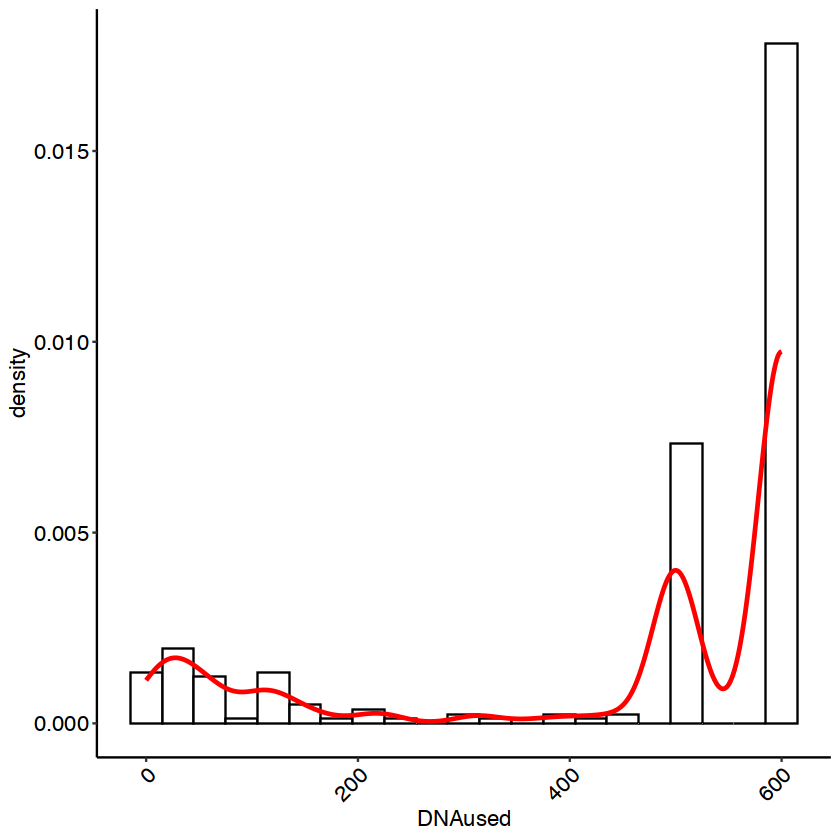

In [34]:
p00

In [35]:
p6 <- ggplot(data = all_stats, aes(x = DNAused, y = TRB)) +
    geom_point() +
    myplot +
    myaxis
p7 <- ggplot(data = all_stats, aes(x = libraryyield, y = TRB)) +
    geom_point() +
    myplot +
    myaxis
p8 <- ggplot(data = all_stats, aes(x = captureyield, y = TRB)) +
    geom_point() +
    myplot +
    myaxis


In [36]:
p9 <- ggplot(data = all_stats, aes(x = Total.sequencing.reads / 1000000, y = TRB)) +
    geom_point() +
    myplot +
    myaxis
p10 <- ggplot(data = all_stats, aes(x = Successfully.aligned.reads / 1000000, y = TRB)) +
    geom_point() +
    myplot +
    myaxis
p11 <- ggplot(data = all_stats, aes(x = percaligned, y = TRB)) +
    geom_point() +
    myplot +
    myaxis


In [37]:
p12 <- ggplot(data = all_stats, aes(x = capbatch, y = TRB)) +
    geom_boxplot() +
    geom_beeswarm(cex = 0.1) +
    myplot +
    myaxis +
    theme(axis.text.x = element_blank())
p13 <- ggplot(data = all_stats, aes(x = libbatch, y = TRB)) +
    geom_boxplot() +
    geom_beeswarm(cex = 0.5) +
    myplot +
    myaxis +
    theme(axis.text.x = element_blank())


In [38]:
pdf(paste0(plotpath, "QC_PBMC.pdf"),
    width = 30, height = 30
)
plot_grid(p1, p2, p3, p4, p5,
    p6, p7, p8, p9, p10,
    p11, p12, p13,
    ncol = 3
)
dev.off()


pdf 
  2

In [39]:
head(all_stats)

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,percaligned
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,CHP_10YO-M_PBMC_DNA,CHP_10YO_M_00,n = 321,4120,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1449.6,13.338,...,2500371,369721,74186,428666,1713555,0,563,0,0,0.7415962
2,CHP_11YO-M_PBMC_DNA,CHP_11YO_M_00,n = 321,4880,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1948.8,6.232,...,3481524,550846,116455,489440,2318341,0,0,0,0,0.7540386
3,CHP_15YO-F-A_PBMC_DNA,CHP_15YO_F_A_00,n = 321,18200,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1545.6,7.942,...,3488717,549330,157638,486162,1686316,1052,0,0,0,0.7519197
4,CHP_15YO-F-B_PBMC_DNA,CHP_15YO_F_B_00,n = 321,35400,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1171.2,7.942,...,5292852,875254,241875,663487,2991528,793,309,0,0,0.7668919
5,CHP_15YO-M_PBMC_DNA,CHP_15YO_M_00,n = 321,7920,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1843.2,6.232,...,4275428,660748,130568,632122,2711248,0,1072,0,0,0.7560349
6,CHP_16YO-M_PBMC_DNA,CHP_16YO_M_00,n = 321,3460,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,2227.2,4.294,...,3382456,472114,117300,452204,2111692,0,0,0,0,0.7574009


In [40]:
summary(all_stats$Total.sequencing.reads)
summary(all_stats$Successfully.aligned.reads)
summary(all_stats$libraryyield)
summary(all_stats$captureyield)
summary(all_stats$percaligned)
summary(all_stats$TRB)
summary(all_stats$Reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  411327  2979214  5234485  6008702  6928447 88611546 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  309359  2274935  4114743  4721116  5505334 68030488 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   12.0   450.2   734.4   990.3  1238.4  8112.0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   4.294   74.860  159.980  280.745  336.300 1311.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6187  0.7292  0.7606  0.7794  0.8398  0.9781 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    45.0   125.0   243.4   351.0  2237.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     10    1046    3282   32445   32506  363060 

## PCA V usage

In [41]:
load(file = paste0(datapath, "capTCRseq/int_load_meta.RData"))

In [42]:
pbmc_pca <- pca_vusage.fx(int_load, pbmc_samples, "PBMC", "FALSE")

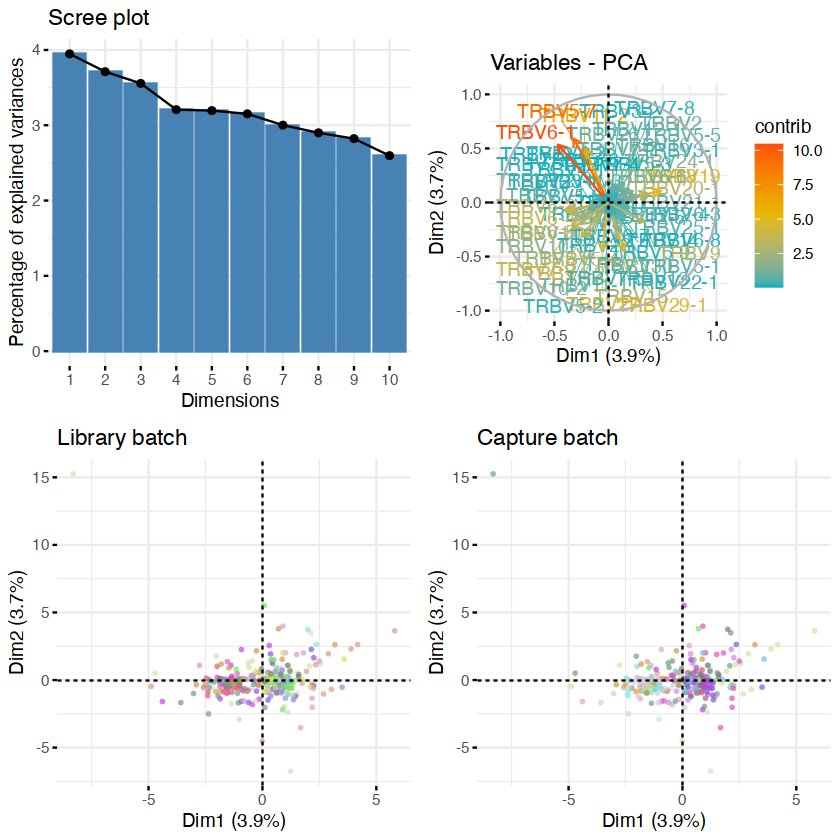

In [43]:
pbmc_pca

In [44]:
pdf(paste0(plotpath, "PBMC_Vusage_PCA.pdf"),
    width = 10, height = 10
)
pbmc_pca
dev.off()


pdf 
  2

## PCA experimental measures

In [45]:
pca_batch <- pca_batch.fx(int_load, pbmc_samples, "PBMC", "FALSE")

In [46]:
    meta <- repFilter(int_load, .method = "by.meta", .query = list(sampletype = include("PBMC")))$meta


In [47]:
    sampleprocessingdta <- pbmc_samples[which(pbmc_samples$TCR == "Yes"), ]


In [48]:
table(pbmc_samples$TCR)


 No Yes 
 43 278 

In [49]:
head(pbmc_samples[which(pbmc_samples$TCR == "Yes"), ])

,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,capbatch,capturepassed,Successful capture,deepseq,Deep sequencing,mysample_id,TCR,TCR analysis,Patient,Tumor,Group
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,n = 321,6160,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,825.6,155.42,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_330_05,Yes,n = 277,CHP_330,OS,NA
2,n = 321,11200,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,2006.4,155.42,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_329_04,Yes,n = 277,CHP_329,HR ALL,NA
3,n = 321,3780,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,1161.6,162.64,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_331_05,Yes,n = 277,CHP_331,SR ALL,NA
4,n = 321,9700,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,1555.2,162.64,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_331_04,Yes,n = 277,CHP_331,SR ALL,NA
5,n = 321,1410,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,508.8,328.70,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_338_05,Yes,n = 277,CHP_338,AML,NA
6,n = 321,2460,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,883.2,328.70,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_338_04,Yes,n = 277,CHP_338,AML,NA


In [50]:
    meta <- cbind(meta, sampleprocessingdta[match(meta$sample_id, sampleprocessingdta$mysample_id), ])


In [52]:

    sampleprocessingdta <- sampleprocessingdta[which(sampleprocessingdta$TCR == "Yes"), ]

    meta <- cbind(meta, sampleprocessingdta[match(meta$sample_id, sampleprocessingdta$mysample_id), ])

    meta <- meta[!is.na(meta$TCR), ]

    meta_subset <- meta[, c(
        "TRB", "Reads", "observed_Shannon",
        "q0_v", "q0_j", "DNAextracted", "DNAused", "libraryyield", "captureyield"
    )]

    rownames(meta_subset) <- meta$sample_id

    mypca <- prcomp(meta_subset, scale. = TRUE, center = TRUE)

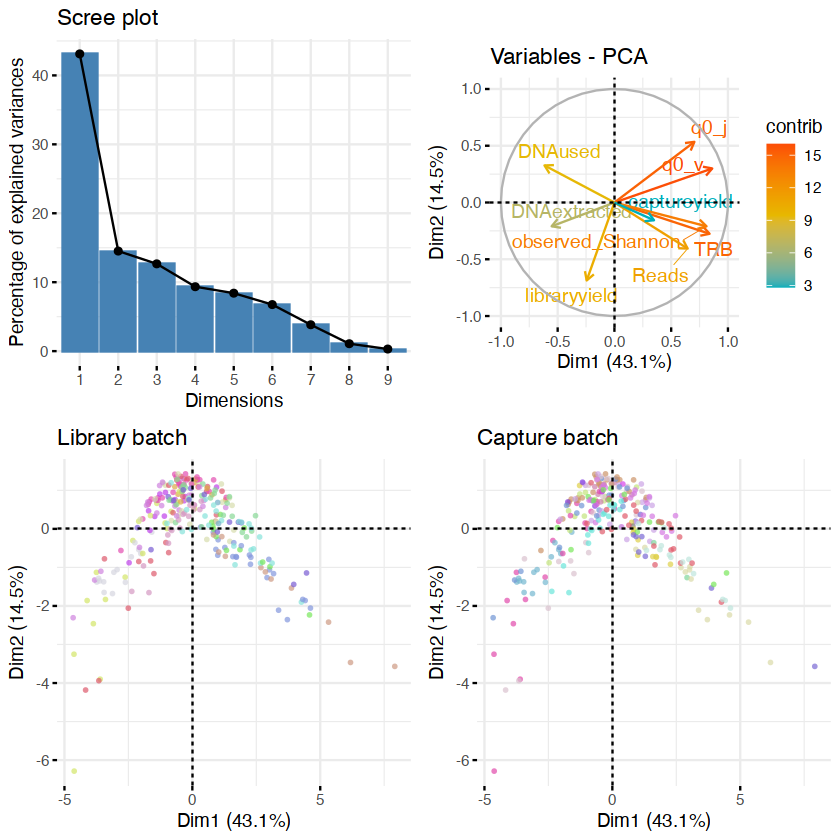

In [53]:
pca_batch

In [54]:
pdf(paste0(plotpath, "PBMC_batch_PCA.pdf"),
    width = 10, height = 10)
pca_batch
dev.off()

pdf 
  2

## Remove samples

In [55]:
summary(all_stats$Total.sequencing.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  411327  2979214  5234485  6008702  6928447 88611546 

In [56]:
summary(all_stats$percaligned)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6187  0.7292  0.7606  0.7794  0.8398  0.9781 

In [57]:
dim(all_stats)

[1] 273 102

In [59]:
head(pbmc_samples,3)

,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,capbatch,capturepassed,Successful capture,deepseq,Deep sequencing,mysample_id,TCR,TCR analysis,Patient,Tumor,Group
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,n = 321,6160,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,825.6,155.42,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_330_05,Yes,n = 277,CHP_330,OS,NA
2,n = 321,11200,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,2006.4,155.42,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_329_04,Yes,n = 277,CHP_329,HR ALL,NA
3,n = 321,3780,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,1161.6,162.64,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_331_05,Yes,n = 277,CHP_331,SR ALL,NA


In [60]:
dim(all_stats)

[1] 273 102

In [61]:
head(all_stats)

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,percaligned
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,CHP_10YO-M_PBMC_DNA,CHP_10YO_M_00,n = 321,4120,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1449.6,13.338,...,2500371,369721,74186,428666,1713555,0,563,0,0,0.7415962
2,CHP_11YO-M_PBMC_DNA,CHP_11YO_M_00,n = 321,4880,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1948.8,6.232,...,3481524,550846,116455,489440,2318341,0,0,0,0,0.7540386
3,CHP_15YO-F-A_PBMC_DNA,CHP_15YO_F_A_00,n = 321,18200,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1545.6,7.942,...,3488717,549330,157638,486162,1686316,1052,0,0,0,0.7519197
4,CHP_15YO-F-B_PBMC_DNA,CHP_15YO_F_B_00,n = 321,35400,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1171.2,7.942,...,5292852,875254,241875,663487,2991528,793,309,0,0,0.7668919
5,CHP_15YO-M_PBMC_DNA,CHP_15YO_M_00,n = 321,7920,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1843.2,6.232,...,4275428,660748,130568,632122,2711248,0,1072,0,0,0.7560349
6,CHP_16YO-M_PBMC_DNA,CHP_16YO_M_00,n = 321,3460,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,2227.2,4.294,...,3382456,472114,117300,452204,2111692,0,0,0,0,0.7574009


In [62]:
pbmc_samples[!pbmc_samples$mysample_id %in% all_stats$mysample_id,]

,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,capbatch,capturepassed,Successful capture,deepseq,Deep sequencing,mysample_id,TCR,TCR analysis,Patient,Tumor,Group
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
34,n = 321,26000.00,600.00,190521_M04827_0204_000000000-D6BKL,Passed,n = 282,3705.600,21.280,190531_M00753_0126_000000000-D6D7Y,Passed,n = 278,Yes,n = 278,CHP_356_04,No,n = 1,CHP_356,NA,NA
49,n = 321,11200.00,600.00,190607_M04827_0206_000000000-D6C75,Passed,n = 282,537.600,84.360,D6WFR,Passed,n = 278,Yes,n = 278,CHP_315_05,Yes,n = 277,CHP_315,NA,NA
58,n = 321,3820.00,600.00,190607_M04827_0206_000000000-D6C75,Passed,n = 282,2697.600,78.660,D6WFR,Passed,n = 278,Yes,n = 278,CHP_303_05,Yes,n = 277,CHP_303,NA,NA
83,n = 321,665.00,600.00,190916_M04827_0264_000000000-D74G2,Passed,n = 282,196.800,5.852,NA,Failed,n = 4,NA,NA,CHP_341_05,No,NA,CHP_341,NA,NA
91,n = 321,695.00,600.00,190916_M04827_0264_000000000-D74G2,Passed,n = 282,600.000,7.334,NA,Failed,n = 4,NA,NA,CHP_351_05,No,NA,CHP_351,NA,NA
93,n = 321,245.05,38.30,191210_M04827_0319_000000000-D7M28,Passed,n = 282,552.000,410.400,201216_M04827_0481_000000000-D9VL2,Passed,n = 278,Yes,n = 278,CHP_336_04,Yes,n = 277,CHP_336,ALL,NA
103,n = 321,745.00,600.00,190916_M04827_0264_000000000-D74G2,Passed,n = 282,950.400,21.090,NA,Failed,n = 4,NA,NA,CHP_339_04,No,NA,CHP_339,NA,NA
164,n = 321,77.00,77.00,NA,Failed,n = 39,41.472,0.000,NA,,NA,NA,NA,CHP_385_05,No,NA,CHP_385,NA,NA
165,n = 321,86.00,86.00,NA,Failed,n = 39,62.880,0.000,NA,,NA,NA,NA,CHP_393_01,No,NA,CHP_393,NA,NA


In [63]:
table(pbmc_samples$`TCR analysis`,useNA = "always")


  n = 1 n = 277    <NA> 
      1     277      43 

In [66]:
dim(all_stats[all_stats$Total.sequencing.reads <= 2000000,])

[1]  22 102

In [67]:
# remove 22 samples with < 2mil reads
subset_pbmc <- all_stats[all_stats$Total.sequencing.reads > 2000000,]

In [69]:
summary(subset_pbmc$DNAused)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   435.7   600.0   450.1   600.0   600.0 

In [70]:
# one sample is 0 ng added in error in lab processing excel file
## remove 38 samples with < 100 ng input DNA

subset_pbmc <- subset_pbmc[ subset_pbmc$DNAused >= 100,]

In [71]:
dim(subset_pbmc)

[1] 213 102

In [72]:
save(subset_pbmc, file = paste0(datapath, "capTCRseq/PBMC_GoodSamples.RData"))

In [73]:
dim(all)
dim(all_stats)

[1] 276  83

[1] 273 102

# cfDNA

In [74]:
load(file = paste0(gitpath, "data/cfdna_sampleprocessing.RData"))

In [75]:
load(file = paste0(datapath,"capTCRseq/meta_div_TRB.RData"))

In [76]:
cfdna_samples$sample_id <- NULL

In [77]:
all <- merge(cfdna_samples, meta_div[ which(meta_div$sampletype == "cfDNA"),], by.x = "mysample_id", by.y = "sample_id")

# divstats_lst_TRB contains all samples with flow data, remove those without tcr data
all <- all[!is.na(all$basename),]

In [78]:
dim(all)

[1] 286  84

In [79]:
all[ all$mysample_id == "CHP_407_01",]

,mysample_id,DNA samples,DNAextracted,DNAused,librarypassed,libbatch,Library preparation,libraryyield,DNAforcapture,captureyield,...,observed_Shannon,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group.y
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
249,CHP_407_01,n = 316,17.12,12.24,Passed,200312_M04827_0373_000000000-D8GDV,n = 316,331.2,331.2,1052.6,...,4.314781,4.316694,0.03156677,4.006012,4.008145,0.02787398,CHP_407-01_cfDNA,remaining_batch_3_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_407-01_cfDNA.txt,cfDNA,CHP


In [83]:
# stats <- read.csv(file = paste0(h4hpath, "data/mixcr/log/align_stats.csv"), header = T)
stats <- read.csv(file = paste0(datapath, "align_stats.csv"), header = T) # also on h4h

In [84]:
stats$basename <- gsub("_barcode.*", "",stats$Input.file.s.)

In [85]:
all_stats <- merge(all, stats, by = "basename")

In [86]:
dim(all)

[1] 286  84

In [87]:
stats[ grepl("CHP_407", stats$Input.file.s.),]


,Input.file.s.,Output.file.s.,Version,Total.sequencing.reads,Successfully.aligned.reads,Alignment.failed..no.hits..not.TCR.IG..,Alignment.failed.because.of.absence.of.CDR3.parts,Alignment.failed.because.of.low.total.score,Alignment.aided.overlaps,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,basename
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
98,"CHP_407-FFPE-DNA_barcode_R1.fastq,CHP_407-FFPE-DNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-FFPE-DNA.vdjca,"2.1.12,repseqio.v1.5",8853479,6328990,958463,120067,1445959,49400,4244031,810533,223657,351418,695181,4170,0,0,0,CHP_407-FFPE-DNA
232,"CHP_407-01_PBMC_DNA_barcode_R1.fastq,CHP_407-01_PBMC_DNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-01_PBMC_DNA.vdjca,"2.1.12,repseqio.v1.5",2108548,1518470,188117,45431,356530,22014,1009989,264165,50046,83628,110453,134,40,15,0,CHP_407-01_PBMC_DNA
289,"CHP_407-02_cfDNA_barcode_R1.fastq,CHP_407-02_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-02_cfDNA.vdjca,"2.1.12,repseqio.v1.5",6035387,5106039,245579,125859,557910,23679,1985513,228653,73677,219833,2598066,226,71,0,0,CHP_407-02_cfDNA
331,"CHP_407-04-PBMC-DNA_barcode_R1.fastq,CHP_407-04-PBMC-DNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-04-PBMC-DNA.vdjca,"2.1.12,repseqio.v1.5",3321851,2880916,107515,88581,244839,71399,1056767,237815,43981,299846,1242402,79,26,0,0,CHP_407-04-PBMC-DNA
409,"CHP_407-03_cfDNA_barcode_R1.fastq,CHP_407-03_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-03_cfDNA.vdjca,"2.1.12,repseqio.v1.5",6927443,6022903,157915,83824,662801,75786,2213725,288698,87448,176513,3256518,0,0,1,0,CHP_407-03_cfDNA
434,"CHP_407-02_PBMC_DNA_barcode_R1.fastq,CHP_407-02_PBMC_DNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-02_PBMC_DNA.vdjca,"2.1.12,repseqio.v1.5",2976358,2148970,256896,80061,490431,29796,1497920,257893,76843,141137,175039,76,55,7,0,CHP_407-02_PBMC_DNA
446,"CHP_407-03__PBMC-DNA_barcode_R1.fastq,CHP_407-03__PBMC-DNA_barcode_R2.fastq",/cluster/projects/pughlab/pediatric/projects/INTERCEPT/data/mixcr/alignments/alignments_CHP_407-03__PBMC-DNA.vdjca,"2.1.12,repseqio.v1.5",6164876,4723218,406708,157466,877484,69960,3217821,571802,138053,341983,453493,23,37,6,0,CHP_407-03__PBMC-DNA


In [88]:
dim(all_stats)

[1] 273 102

In [89]:
all_stats$percaligned <- all_stats$Successfully.aligned.reads/all_stats$Total.sequencing.reads

In [90]:
summary(all_stats$percaligned)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6693  0.7624  0.8662  0.8368  0.8810  0.9278 

In [91]:
summary(all_stats$Total.sequencing.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   22839  3864097  4818585  5494947  6460983 15814720 

In [92]:
summary(all_stats$Successfully.aligned.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   20740  3116790  4144627  4653997  5649130 13734626 

In [93]:
p1 <- histdenp(all_stats, "Total.sequencing.reads/1000000", 1)
p2 <- histdenp(all_stats, "Successfully.aligned.reads/1000000", 1)
p3 <- histdenp(all_stats, "percaligned", 0.01)

In [94]:
p4 <- histdenp(all_stats, "TRB", 5)
p5 <- histdenp(all_stats, "Reads/100", 5)

In [95]:
p6 <- ggplot(data = all_stats, aes( x = DNAused, y = TRB)) + geom_point() + myplot + myaxis
p7 <- ggplot(data = all_stats, aes( x = libraryyield, y = TRB)) + geom_point() + myplot + myaxis
p8 <- ggplot(data = all_stats, aes( x = captureyield, y = TRB)) + geom_point() + myplot + myaxis

In [96]:
p9 <- ggplot(data = all_stats, aes( x = Total.sequencing.reads/1000000, y = TRB)) + geom_point() + myplot + myaxis
p10 <- ggplot(data = all_stats, aes( x = Successfully.aligned.reads/1000000, y = TRB)) + geom_point() + myplot + myaxis
p11 <- ggplot(data = all_stats, aes( x = percaligned, y = TRB)) + geom_point() + myplot + myaxis

In [97]:
p12 <- ggplot(data = all_stats, aes( x = capbatch, y = TRB)) + geom_boxplot() +geom_beeswarm(cex = 0.1)+ myplot + myaxis +
theme( axis.text.x = element_blank())
p13 <- ggplot(data = all_stats, aes( x = libbatch, y = TRB)) + geom_boxplot() +geom_beeswarm(cex = 0.5) + myplot + myaxis +
theme( axis.text.x = element_blank())

In [98]:
pdf(paste0(plotpath, "QC_cfDNA.pdf"),
    width = 30, height = 30)
plot_grid(p1,p2, p3, p4, p5, p6,p7,p8,p9,p10, p11,p12,p13, ncol = 3)
dev.off()

Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”


Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”


pdf 
  2

In [99]:
summary(all_stats$Total.sequencing.reads)
summary(all_stats$Successfully.aligned.reads)
summary(all_stats$libraryyield)
summary(all_stats$captureyield)
summary(all_stats$percaligned)
summary(all_stats$TRB)
summary(all_stats$Reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   22839  3864097  4818585  5494947  6460983 15814720 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   20740  3116790  4144627  4653997  5649130 13734626 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.82  205.44  324.48  352.89  461.76 1017.60 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  104.5   315.4   543.4   609.1   832.2  1641.6       1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6693  0.7624  0.8662  0.8368  0.8810  0.9278 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    3.00    7.00   14.44   16.00  220.00       8 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      1     352    3036    6663    7906   88874       8 

## PCA V usage

In [100]:
load(file = paste0(gitpath, "data/cfdna_sampleprocessing.RData"))

In [101]:
load(file = paste0(datapath, "capTCRseq/int_load_meta.RData"))

In [102]:
cfdna_pca <- pca_vusage.fx(int_load, cfdna_samples, "cfDNA", "FALSE")

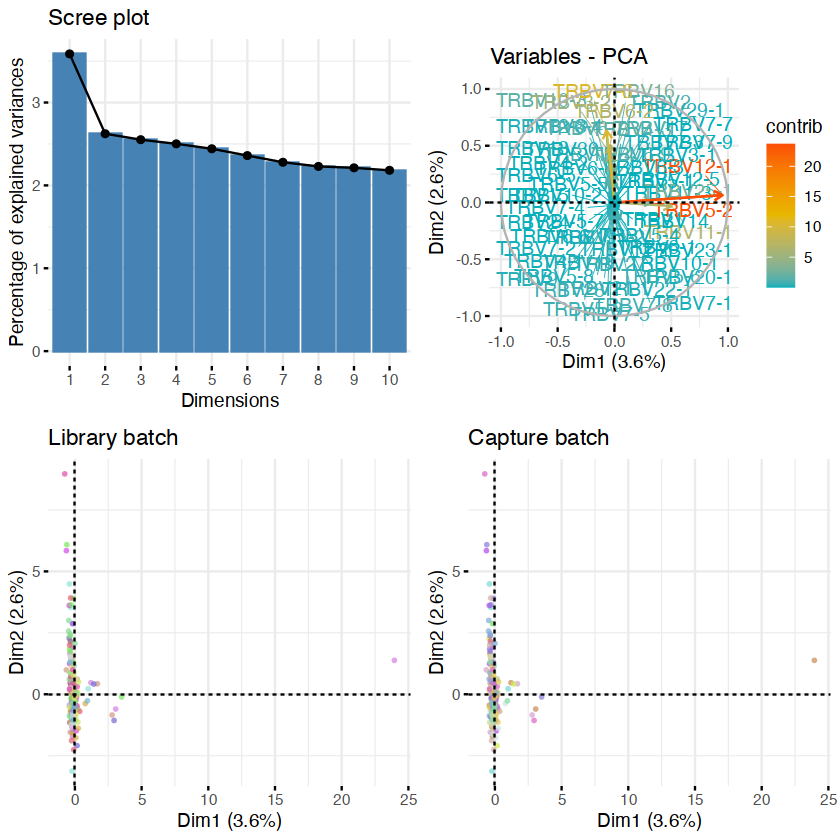

In [103]:
cfdna_pca

In [104]:
pdf(paste0(plotpath, "cfDNA_Vusage_PCA.pdf"),
    width = 10, height = 10)
cfdna_pca
dev.off()

pdf 
  2

In [105]:
head(int_load$meta)

Sample,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,Pass,...,q0_aa,q0_v,q0_j,q0_aav,q0_vj,q1_aa,q1_v,q1_j,q1_aav,q1_vj
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CHP_10YO-M_PBMC_DNA,CHP_10YO_M_00,CHP_10YO_M,X00,NA,NA,NA,Normal,NA,NA,...,22,16,8,22,12.0,12.787814,9.563643,5.074581,12.787814,7.319112
CHP_11YO-M_PBMC_DNA,CHP_11YO_M_00,CHP_11YO_M,X00,NA,NA,NA,Normal,NA,NA,...,21,15,11,21,13.0,14.411620,11.695680,8.890122,14.411620,10.292901
CHP_15YO-F-A_PBMC_DNA,CHP_15YO_F_A_00,CHP_15YO_F_A,X00,NA,NA,NA,Normal,NA,NA,...,13,12,8,13,10.0,10.930258,9.683620,6.059679,10.930258,7.871649
CHP_15YO-F-B_PBMC_DNA,CHP_15YO_F_B_00,CHP_15YO_F_B,X00,NA,NA,NA,Normal,NA,NA,...,9,8,7,9,7.5,8.294830,6.692670,6.084720,8.294830,6.388695
CHP_15YO-M_PBMC_DNA,CHP_15YO_M_00,CHP_15YO_M,X00,NA,NA,NA,Normal,NA,NA,...,33,22,10,33,16.0,29.070103,20.127211,7.641330,29.070103,13.884271
CHP_16YO-M_PBMC_DNA,CHP_16YO_M_00,CHP_16YO_M,X00,NA,NA,NA,Normal,NA,NA,...,7,6,6,7,6.0,5.495512,5.434412,4.355165,5.495512,4.894789


In [110]:
temp <- repFilter(int_load, .method = "by.meta", .query = list(Sample = exclude("CHP_374-05-cfDNA")))

In [111]:
cfdna_pca <- pca_vusage.fx(temp, cfdna_samples, "cfDNA", "FALSE")

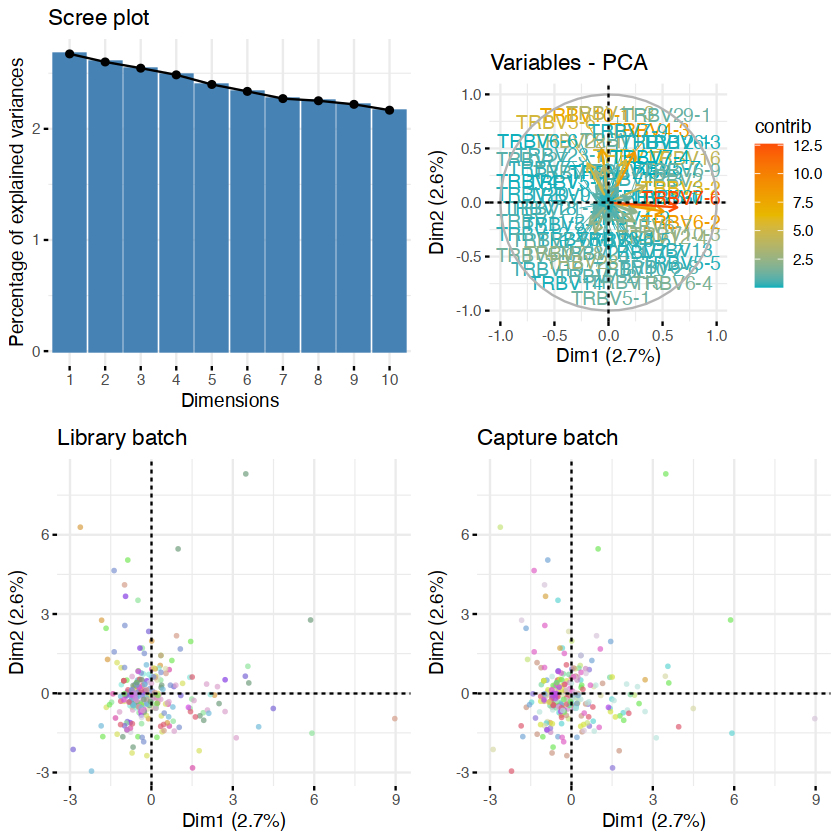

In [112]:
cfdna_pca

## PCA experimental measures

In [113]:
pca_batch <- pca_batch.fx(int_load, cfdna_samples, "cfDNA", "FALSE")

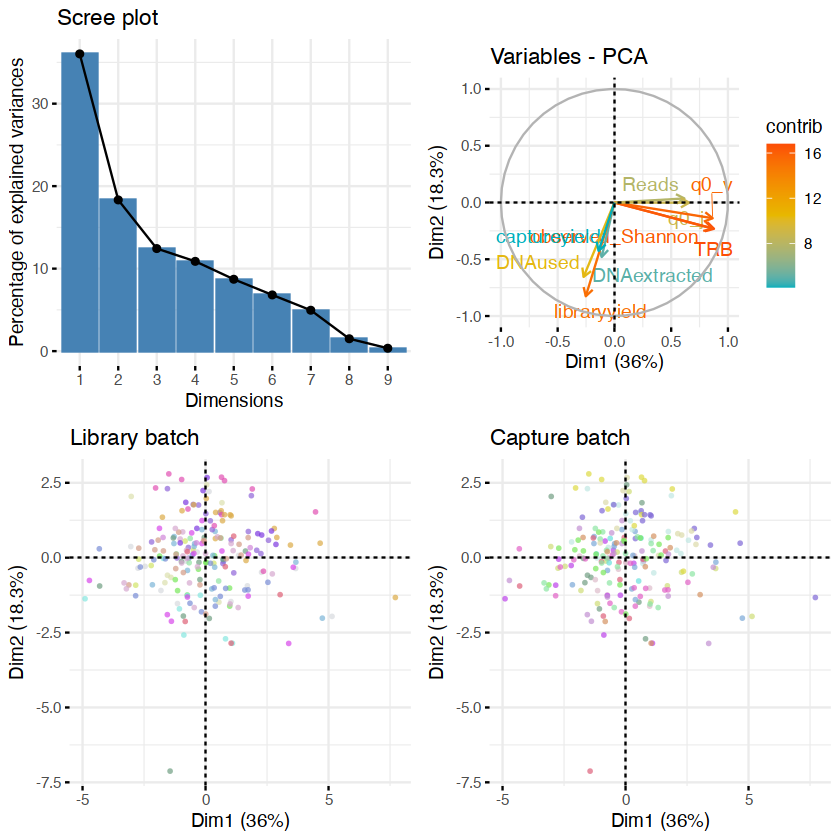

In [114]:
pca_batch

In [115]:
pdf(paste0(plotpath, "cfDNA_batch_PCA.pdf"),
    width = 10, height = 10)
pca_batch
dev.off()

pdf 
  2

## Remove samples

In [116]:
summary(all_stats$Total.sequencing.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   22839  3864097  4818585  5494947  6460983 15814720 

In [117]:
summary(all_stats$percaligned)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6693  0.7624  0.8662  0.8368  0.8810  0.9278 

In [119]:
dim(all_stats[all_stats$Total.sequencing.reads<=  2000000,])

[1]   7 103

In [120]:
# remove 7 samples with < 2mil reads
subset_cfdna <- all_stats[all_stats$Total.sequencing.reads > 2000000,]

In [121]:
dim(subset_cfdna)

[1] 266 103

In [122]:
# remove the outlier from V usage, CHP_374-05-cfDNA It is an EWS case with one TRB and 3 reads.

In [123]:
subset_cfdna <- subset_cfdna[!grepl("CHP_374-05-cfDNA", subset_cfdna$basename),]

In [124]:
dim(subset_cfdna)

[1] 265 103

In [125]:
colnames(subset_cfdna)

[1] "basename"                                         
  [2] "mysample_id"                                      
  [3] "DNA samples"                                      
  [4] "DNAextracted"                                     
  [5] "DNAused"                                          
  [6] "librarypassed"                                    
  [7] "libbatch"                                         
  [8] "Library preparation"                              
  [9] "libraryyield"                                     
 [10] "DNAforcapture"                                    
 [11] "captureyield"                                     
 [12] "capbatch"                                         
 [13] "capturepassed"                                    
 [14] "Successful capture"                               
 [15] "deepseq"                                          
 [16] "Deep sequencing"                                  
 [17] "TCR"                                              
 [18] "TCR analysis"                                     
 [19] "Patient.x"                                        
 [20] "Tumor"                                            
 [21] "Group.x"                                          
 [22] "Patient.y"                                        
 [23] "cycle"                                            
 [24] "FOLD"                                             
 [25] "ATC"                                              
 [26] "Age"                                              
 [27] "Disease_type"                                     
 [28] "TE_fold"                                          
 [29] "CD3"                                              
 [30] "EM"                                               
 [31] "CM"                                               
 [32] "Naïve"                                            
 [33] "SCM"                                              
 [34] "TE"                                               
 [35] "EM%"                                              
 [36] "CM%"                                              
 [37] "Naïve%"                                           
 [38] "SCM%"                                             
 [39] "TE%"                                              
 [40] "Naïve/TE"                                         
 [41] "N+CM+SCM/TE+EM"                                   
 [42] "PD-1"                                             
 [43] "PDL1"                                             
 [44] "LAG3"                                             
 [45] "TIM3"                                             
 [46] "CTLA4"                                            
 [47] "PD1%"                                             
 [48] "PDL1%"                                            
 [49] "LAG3%"                                            
 [50] "TIM3%"                                            
 [51] "CTLA4%"                                           
 [52] "Any NCR"                                          
 [53] "PD1 + LAG3 + TIM3"                                
 [54] "cancergroup"                                      
 [55] "agegroup"                                         
 [56] "foldgroup"                                        
 [57] "Remission"                                        
 [58] "Relapse"                                          
 [59] "Transplant"                                       
 [60] "CART"                                             
 [61] "vital_status"                                     
 [62] "LOF"                                              
 [63] "TRB"                                              
 [64] "Reads"                                            
 [65] "CPKR"                                             
 [66] "Average_reads"                                    
 [67] "VMR"                                              
 [68] "Max_reads"                                        
 [69] "Singletons"                                       


In [126]:
summary(subset_cfdna$DNAused)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.002  15.540  20.000  17.371  20.000  20.000 

In [127]:
subset_cfdna[ subset_cfdna$DNAused < 5, ]

,basename,mysample_id,DNA samples,DNAextracted,DNAused,librarypassed,libbatch,Library preparation,libraryyield,DNAforcapture,...,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,percaligned
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
101,CHP_365-05_cfDNA,CHP_365_05,n = 316,0.6,4.956,Passed,200604_M04827_0388_000000000-D8756,n = 316,73.44,73.44,...,1184597,130589,32676,185880,1580458,0,0,0,0,0.8895689
141,CHP_378-03_cfDNA,CHP_378_03,n = 316,0.4,4.928,Passed,200604_M04827_0388_000000000-D8756,n = 316,128.64,128.64,...,2101815,242297,80375,168265,2795981,120,0,0,0,0.8684310
187,CHP_391-04_cfDNA,CHP_391_04,n = 316,0.4,3.002,Passed,200604_M04827_0388_000000000-D8756,n = 316,84.96,84.96,...,1996636,236779,72417,220362,3116877,0,0,0,0,0.8882489
268,CHP_419-01_cfDNA,CHP_419_01,n = 316,0.4,4.730,Passed,200604_M04827_0388_000000000-D8756,n = 316,121.92,121.92,...,2790707,290355,89882,367018,4388924,0,163,0,0,0.8799967


In [128]:
subset_cfdna <- subset_cfdna[ subset_cfdna$DNAused >= 5, ]

In [129]:
dim(subset_cfdna)

[1] 261 103

In [130]:
save(subset_cfdna, file = paste0(datapath, "capTCRseq/cfDNA_GoodSamples.RData"))